scrp de algunos datos

In [ ]:

import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import zipfile

from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time


En este link encontramos todos los partidos de la temporada 2024/25, con un link al partido, que incluye más información del partido.  
https://www.daikin-hbl.de/en/hbl/schedule?~w=fl~eJyrVspRslJQSs3TdfVT0lFQKgbxkhOTktNMDSx1TYzNjXUNDVPTdBONzQ10LVOMkw1TLQ2MjE0SQYqrQIqDXINDfUKClWoBwtESuw

## EXTRAER LOS RESULTADOS DE TODAS LAS TEMPORADAS

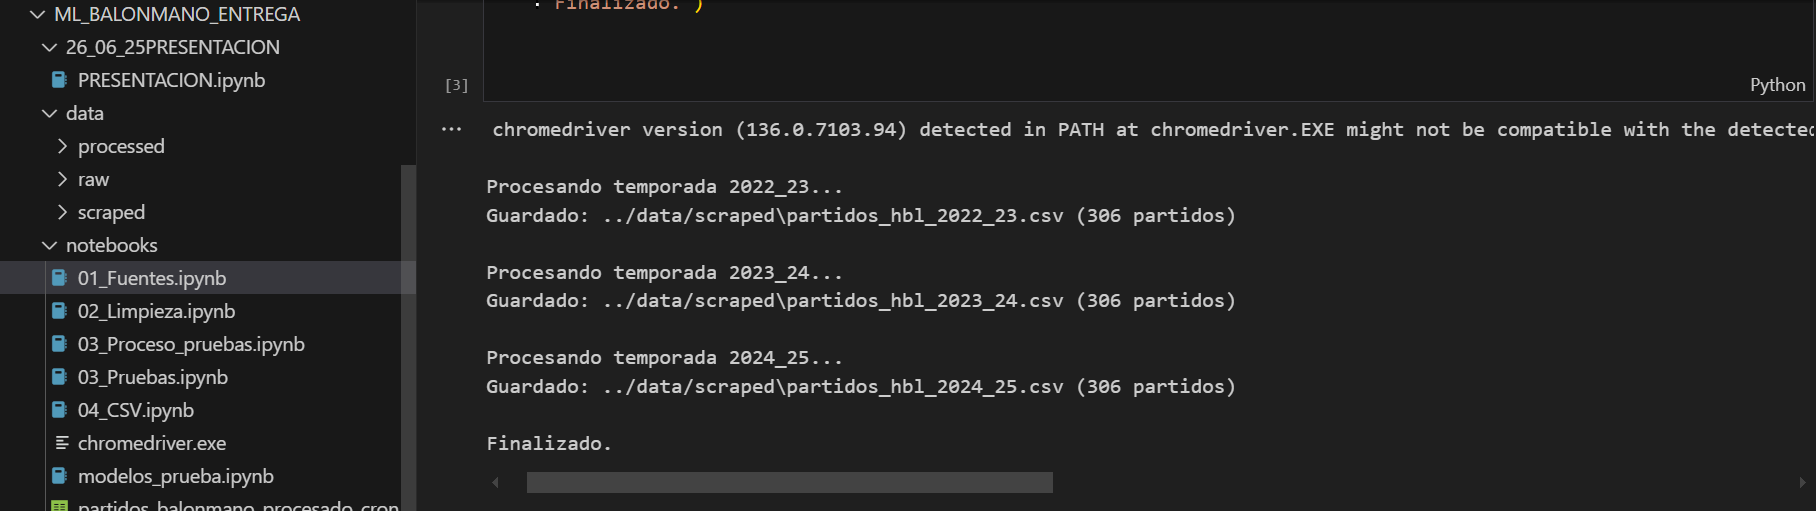

In [1]:
import pandas as pd

# Cargar los archivos CSV subidos
file_paths = [
    "../data/scraped/partidos_hbl_2022_23.csv",
    "../data/scraped/partidos_hbl_2023_24.csv",
    "../data/scraped/partidos_hbl_2024_25.csv"
]

# Leer y concatenar todos los CSVs
df = pd.concat([pd.read_csv(path) for path in file_paths], ignore_index=True)

# Eliminar la columna 'Link' si existe
if 'Link' in df.columns:
    df = df.drop(columns=['Link'])

# Asegurar que la columna 'Resultado' es string
df['Resultado'] = df['Resultado'].astype(str)

# Extraer goles locales y visitantes
resultado_extr = df['Resultado'].str.extract(r'(\d+)\s*-\s*(\d+)')
df['goles_locales'] = pd.to_numeric(resultado_extr[0], errors='coerce')
df['goles_visitante'] = pd.to_numeric(resultado_extr[1], errors='coerce')

# Calcular goles totales
df['goles_totales'] = df['goles_locales'] + df['goles_visitante']

# Calcular victoria del equipo local (1 si ganó el local, 0 en caso contrario)
df['victoria_local'] = (df['goles_locales'] > df['goles_visitante']).astype(int)

# Calcular si hubo más de 60 goles en total
df['Over_60'] = (df['goles_totales'] > 60).astype(int)

# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

# Ordenar de más reciente a más antigua
df = df.sort_values(by='Fecha', ascending=False).reset_index(drop=True)

# Formatear la columna 'Fecha' a Día/Mes/Año (después de ordenar)
df['Fecha'] = df['Fecha'].dt.strftime('%d/%m/%Y')

df.to_csv("../data/processed/total_temporadas.csv")
df


,Fecha,Equipo local,Equipo visitante,Resultado,Jornada,victoria_local,goles_locales,goles_visitante,goles_totales,victoria_local,Over_60
0,08/06/2025,SG BBM Bietigheim,SC Magdeburg,25 - 35,34,NaN,25,35,60,0,0
1,08/06/2025,TBV Lemgo Lippe,FRISCH AUF! Göppingen,29 - 29,34,NaN,29,29,58,0,0
2,08/06/2025,SG Flensburg-Handewitt,Handball Sport Verein Hamburg,40 - 37,34,NaN,40,37,77,1,1
3,08/06/2025,HSG Wetzlar,HC Erlangen,21 - 25,34,NaN,21,25,46,0,0
4,08/06/2025,Rhein-Neckar Löwen,Füchse Berlin,33 - 38,34,NaN,33,38,71,0,1
...,...,...,...,...,...,...,...,...,...,...,...
913,03/09/2022,Rhein-Neckar Löwen,MT Melsungen,36 - 25,1,NaN,36,25,61,1,1
914,01/09/2022,TSV Hannover-Burgdorf,SC DHfK Leipzig,25 - 22,1,NaN,25,22,47,1,0
915,01/09/2022,TBV Lemgo Lippe,VfL Gummersbach,26 - 30,1,NaN,26,30,56,0,0
916,01/09/2022,HC Erlangen,HSG Wetzlar,31 - 27,1,NaN,31,27,58,1,0


In [2]:
# Cargar el archivo combinado y procesado
df = pd.read_csv("../data/processed/total_temporadas.csv")

# Asegurarse de que los goles son numéricos
df['goles_locales'] = pd.to_numeric(df['goles_locales'], errors='coerce')
df['goles_visitante'] = pd.to_numeric(df['goles_visitante'], errors='coerce')
df['goles_totales'] = pd.to_numeric(df['goles_totales'], errors='coerce')
df['victoria_local'] = df['victoria_local'].astype(int)
df['Over_60'] = df['Over_60'].astype(int)

# Codificar los equipos
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Local ID'] = le.fit_transform(df['Equipo local'])
df['Visitante ID'] = le.transform(df['Equipo visitante'])

# Preparar las variables de entrada
X = df[['Local ID', 'Visitante ID', 'goles_locales', 'goles_visitante', 'victoria_local']]

# Objetivo 1: Over_60
y_over60 = df['Over_60']
# Objetivo 2: victoria_local
y_victoria = df['victoria_local']

# Separar en train/test y entrenar modelos
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_over60, test_size=0.2, random_state=42)
clf_over60 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_over60.fit(X_train1, y_train1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_victoria, test_size=0.2, random_state=42)
clf_victoria = RandomForestClassifier(n_estimators=100, random_state=42)
clf_victoria.fit(X_train2, y_train2)

# Reportes
over60_report = classification_report(y_test1, clf_over60.predict(X_test1), output_dict=True)
victoria_report = classification_report(y_test2, clf_victoria.predict(X_test2), output_dict=True)

print("\n Clasificación Over/Under 60 goles")
print(classification_report(y_test1, clf_over60.predict(X_test1)))





 Clasificación Over/Under 60 goles
              precision    recall  f1-score   support

           0       0.96      0.99      0.98        99
           1       0.99      0.95      0.97        85

    accuracy                           0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Cargar datos
# -----------------------------
df = pd.read_csv("../data/processed/total_temporadas.csv")

# Asegurar tipos
df['goles_locales'] = pd.to_numeric(df['goles_locales'], errors='coerce')
df['goles_visitante'] = pd.to_numeric(df['goles_visitante'], errors='coerce')
df['goles_totales'] = pd.to_numeric(df['goles_totales'], errors='coerce')
df['victoria_local'] = df['victoria_local'].astype(int)
df['Over_60'] = df['Over_60'].astype(int)

# -----------------------------
# Codificar equipos
# -----------------------------
le = LabelEncoder()
df['Local ID'] = le.fit_transform(df['Equipo local'])
df['Visitante ID'] = le.transform(df['Equipo visitante'])

# -----------------------------
# Entrenamiento modelos

# Solo usamos variables conocidas antes del partido
X = df[['Local ID', 'Visitante ID']]
y_over60 = df['Over_60']
y_victoria = df['victoria_local']

# Modelo Over/Under 60 goles
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_over60, test_size=0.2, random_state=42)
clf_over60 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_over60.fit(X_train1, y_train1)

# Modelo Victoria local
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_victoria, test_size=0.2, random_state=42)
clf_victoria = RandomForestClassifier(n_estimators=100, random_state=42)
clf_victoria.fit(X_train2, y_train2)

# -----------------------------
# Reportes de evaluación

print("\n Clasificación Over/Under 60 goles")
print(classification_report(y_test1, clf_over60.predict(X_test1)))

print("\n Clasificación Victoria Local")
print(classification_report(y_test2, clf_victoria.predict(X_test2)))

# -----------------------------
# Función para predecir

def predecir(local, visitante):
    try:
        local_id = le.transform([local])[0]
        visitante_id = le.transform([visitante])[0]
    except ValueError:
        print(" Uno de los equipos no existe en los datos.")
        return

    X_input = pd.DataFrame([[local_id, visitante_id]], columns=['Local ID', 'Visitante ID'])

    proba_60 = clf_over60.predict_proba(X_input)[0][1]
    proba_victoria = clf_victoria.predict_proba(X_input)[0][1]

    print(f"\n Partido: {local} vs {visitante}")
    print(f" Probabilidad de +60 goles: {proba_60:.2%}")
    print(f" Probabilidad de victoria local: {proba_victoria:.2%}")

# -----------------------------
# Ejemplo

predecir("THW Kiel", "SC Magdeburg")


 Clasificación Over/Under 60 goles
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        99
           1       0.56      0.47      0.51        85

    accuracy                           0.59       184
   macro avg       0.58      0.58      0.58       184
weighted avg       0.58      0.59      0.58       184


 Clasificación Victoria Local
              precision    recall  f1-score   support

           0       0.53      0.68      0.59        65
           1       0.79      0.67      0.73       119

    accuracy                           0.67       184
   macro avg       0.66      0.67      0.66       184
weighted avg       0.70      0.67      0.68       184


 Partido: THW Kiel vs SC Magdeburg
 Probabilidad de +60 goles: 35.17%
 Probabilidad de victoria local: 29.40%


c:\Users\inaki\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\inaki\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [5]:
df_over60

,Modelo,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.586957,0.563380,0.470588,0.512821,0.604872
1,Logistic Regression,0.538043,0.000000,0.000000,0.000000,0.585264
2,SVM,0.538043,0.000000,0.000000,0.000000,0.431610
3,KNN,0.570652,0.553571,0.364706,0.439716,0.589067
4,Gradient Boosting,0.614130,0.666667,0.329412,0.440945,0.660547


In [6]:
df_victoria


,Modelo,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.673913,0.792079,0.672269,0.727273,0.751454
1,Logistic Regression,0.597826,0.677165,0.722689,0.699187,0.574014
2,SVM,0.625000,0.715517,0.697479,0.706383,0.621396
3,KNN,0.684783,0.808081,0.672269,0.733945,0.734712
4,Gradient Boosting,0.711957,0.805556,0.731092,0.766520,0.776794
